In [1]:
import habitat

/home/green-tea/miniconda3/envs/habitat/lib/python3.6/site-packages/numba-0.46.0-py3.6-linux-x86_64.egg/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [13]:
import coco

/home/green-tea/miniconda3/envs/habitat/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/green-tea/miniconda3/envs/habitat/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/green-tea/miniconda3/envs/habitat/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/green-tea/miniconda3/envs

In [2]:
config = habitat.get_config("/home/green-tea/all_projects/habitat/segmentation/configs/challenge_objectnav2020.local.rgbd.yaml")

In [3]:
config.defrost()

config.DATASET.DATA_PATH = "/home/green-tea/all_stash/matterport3D/data/val_mini.json.gz"
config.DATASET.SCENES_DIR = "/home/green-tea/all_stash/matterport3D/data4/v1/tasks"

config.SIMULATOR.AGENT_0.SENSORS.append('SEMANTIC_SENSOR')

config.freeze()

In [4]:
env = habitat.Env(config)

2020-04-08 15:49:18,777 Initializing dataset ObjectNav-v1
2020-04-08 15:49:18,822 initializing sim Sim-v0
I0408 15:49:24.334528 27342 simulator.py:143] Loaded navmesh /home/green-tea/all_stash/matterport3D/data4/v1/tasks/mp3d/x8F5xyUWy9e/x8F5xyUWy9e.navmesh
I0408 15:49:24.335299 27342 simulator.py:155] Recomputing navmesh for agent's height 0.88 and radius 0.18.
2020-04-08 15:49:24,432 Initializing task ObjectNav-v1


In [5]:
scene = env.sim.semantic_annotations()
index_to_title_map = {obj.category.index(): obj.category.name() for obj in scene.objects }
index_to_title_map[-1] = 'nope'
print(index_to_title_map)

{1: 'wall', 40: 'misc', 16: 'stairs', 4: 'door', 2: 'floor', 39: 'objects', 17: 'ceiling', 0: 'void', 14: 'plant', 24: 'column', -1: 'nope', 5: 'table', 21: 'mirror', 15: 'sink', 7: 'cabinet', 28: 'lighting', 34: 'seating', 20: 'towel', 12: 'curtain', 9: 'window', 23: 'shower', 38: 'clothes', 11: 'bed', 35: 'board_panel', 37: 'appliances', 31: 'shelving', 26: 'counter', 22: 'tv_monitor', 3: 'chair'}


In [6]:
num_classes = len(list(index_to_title_map.keys()))

In [16]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    # Give the configuration a recognizable name
    NAME = "habitat"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = num_classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 480

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 64, 128, 256, 480)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
#     TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  480
IMAGE_META_SIZE                41
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [480 480   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [17]:
import mrcnn.model as modellib

In [18]:
COCO_MODEL_PATH = "/home/green-tea/all_projects/habitat/mask-r-cnn/mask_rcnn_coco.h5"
MODEL_DIR = "/home/green-tea/all_projects/habitat/mask-r-cnn/logs"

In [6]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [7]:
config = habitat.get_config("/home/green-tea/all_projects/habitat/segmentation/configs/challenge_objectnav2020.local.rgbd.yaml")

In [8]:
config.defrost()

config.DATASET.DATA_PATH = "/home/green-tea/all_stash/matterport3D/data/val_mini.json.gz"
config.DATASET.SCENES_DIR = "/home/green-tea/all_stash/matterport3D/data4/v1/tasks"

config.SIMULATOR.AGENT_0.SENSORS.append('SEMANTIC_SENSOR')

config.freeze()

In [9]:
env = habitat.Env(config)

2020-04-05 19:56:43,457 Initializing dataset ObjectNav-v1
2020-04-05 19:56:43,663 initializing sim Sim-v0
I0405 19:56:48.973791 6415 simulator.py:143] Loaded navmesh /home/green-tea/all_stash/matterport3D/data4/v1/tasks/mp3d/x8F5xyUWy9e/x8F5xyUWy9e.navmesh
I0405 19:56:48.974529 6415 simulator.py:155] Recomputing navmesh for agent's height 0.88 and radius 0.18.
2020-04-05 19:56:49,070 Initializing task ObjectNav-v1


In [10]:
observations = env.reset()

In [12]:
from mrcnn import visualize

In [25]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [26]:
results = model.detect([observations['rgb']], verbose=1)

NameError: name 'model' is not defined

In [27]:
print(r['class_ids'], class_names[14])

NameError: name 'r' is not defined

In [28]:
def prepare_semantic_observation(observations):
    scene = env.sim.semantic_annotations()
    instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}
    mapping = np.array([ instance_id_to_label_id[i] for i in range(len(instance_id_to_label_id)) ])

    return np.take(mapping, observations['semantic'])

In [29]:
import numpy as np

In [30]:
scene = env.sim.semantic_annotations()
instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}
mapping = np.array([ instance_id_to_label_id[i] for i in range(len(instance_id_to_label_id)) ])

In [31]:
index_to_title_map = {obj.category.index(): obj.category.name() for obj in scene.objects }

In [32]:
import matplotlib.colors as mcolors

colors = list(mcolors.CSS4_COLORS.values())

new_colors = []

for index in np.round(np.linspace(0, 147, 40)).astype(int):
    new_colors.append(colors[index])
    
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('test', new_colors, N=len(new_colors))

In [33]:
def plot_colortable(colors, title, sort_colors=True, emptycols=0):
    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    topmargin = 40

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
        names = [name for hsv, name in by_hsv]
    else:
        names = list(colors)

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left")

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        swatch_end_x = cell_width * col + swatch_width
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.hlines(y, swatch_start_x, swatch_end_x,
                  color=colors[name], linewidth=18)
        
    plt.show()

1 wall


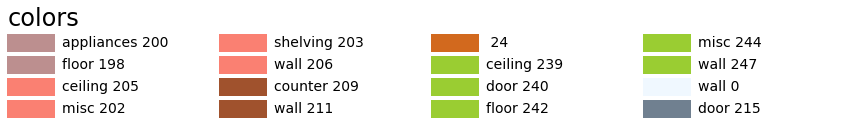

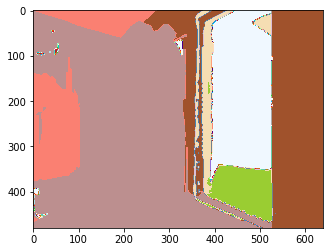

In [35]:
goal = mapping[observations['objectgoal'][0]] 
print(goal, index_to_title_map[goal])
    
# semantic_image = prepare_semantic_observation(observations)
semantic_image = observations['semantic']
elements_in_image = []
    
for string in semantic_image:
    for el in string:
        if not(el in elements_in_image):
            elements_in_image.append(el)
                
raw_data = elements_in_image
    
colors = {}
for entry in raw_data:
    label = index_to_title_map[mapping[entry]] + ' ' + str(entry)
    denum = max(raw_data) - min(raw_data)
        
    if denum == 0:
        denum = len(new_colors)
        
    value = int(round((entry) * len(new_colors) / denum))
    colors[label] = cmap(value)
        
plot_colortable(colors, 'colors')
    
plt.imshow(semantic_image, cmap=cmap)
plt.show()

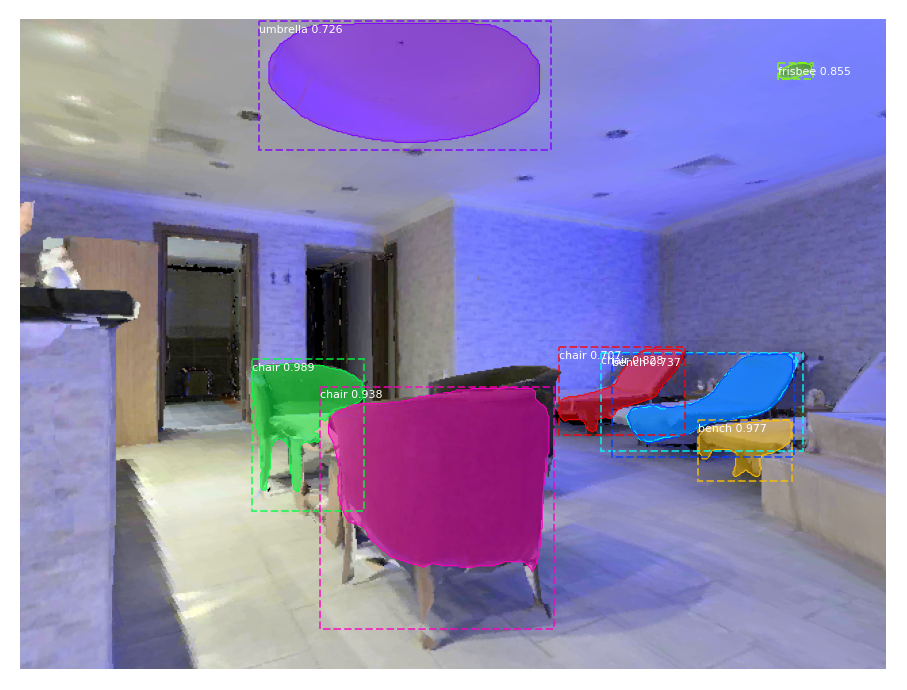

In [27]:

# Visualize results
r = results[0]
visualize.display_instances(observations['rgb'], r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

(3, 480, 640)


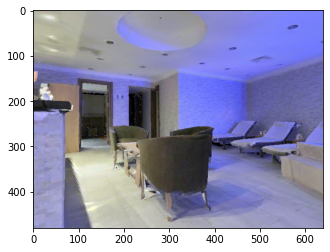

In [24]:
import matplotlib.pyplot as plt

# observations = env.reset()
plt.imshow(observations['rgb'])

In [11]:
observations = env.reset()

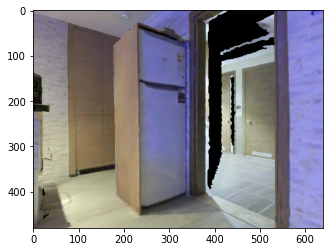

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(observations['rgb'])
plt.show()

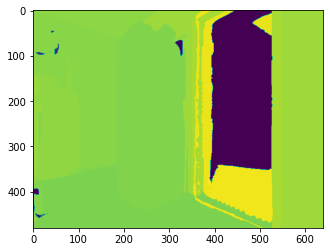

In [13]:
plt.imshow(observations['semantic'])

In [23]:
print(observations['semantic'])
uniq = np.unique(observations['semantic']
                 
for 

[[205 205 205 ... 211 211 211]
 [205 205 205 ... 211 211 211]
 [203 203 203 ... 211 211 211]
 ...
 [198 198 198 ... 211 211 211]
 [198 198 198 ... 211 211 211]
 [198 198 198 ... 211 211 211]]
[  0  24 198 200 202 203 205 206 209 211 215 239 240 242 244 247]


In [18]:
scene = env.sim.semantic_annotations()
instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}
mapping = np.array([ instance_id_to_label_id[i] for i in range(len(instance_id_to_label_id)) ])

index_to_title_map = {obj.category.index(): obj.category.name() for obj in scene.objects }

In [19]:
print(mapping)

[ 1 40  1 16  4  2  4 39  4  1 17  0  1  1 40  4  1  1 14  4 24  1  0  1
 -1 39 17  4  5  1  1 39 21  1  2  1 15 39 40  1  1  4  1  7 28 39 40 28
 40 40 39 40 39 39 39 39 39  2 17  1 40  1  1  5  1 34 15  1 15  1 20  1
 15  1 15 20 20 39  4 39 39 39 39 39 28 28 28 40  1 12  9  1  0  4  4 40
 23 17  2  1  1  4 23 39  2 17 40 40 34  1 34  1  1  9  1 28  9  4 28 39
 28 40  2 28 28 38  4  4  0 11  1 17  1  1  7  0 15 40  0 21  1  7  4  0
 28  4  1  4 39  2 39 39 20 39 39 39 39 39 39 23  2  1  1  1  4 23  4 17
  1 24 40  1  1 24  1  4 17 14  4  4  4  1 14 28  4  4 14 35 39 28 28 28
 39  2 28 16  2 39  2  1 37  7 40 31  1 17  1  4  1 26  4  1  1  4  7  4
 20  1 20 22 40 40  3 40  3  3 16  5 39  5 20 39  3  3  3  3  3 20 20 17
  4  1  2  1 40 38  4  1 17  1  1 40  2 17 40  1 17  9  9  1 39 16  9  9
 40 40 40  4  1 17 40 26  1  2 16  1 39]


In [21]:
for i in range(len(mapping)):
    print(str(i) + ": " + index_to_title_map[mapping[i]])

0: wall
1: misc
2: wall
3: stairs
4: door
5: floor
6: door
7: objects
8: door
9: wall
10: ceiling
11: void
12: wall
13: wall
14: misc
15: door
16: wall
17: wall
18: plant
19: door
20: column
21: wall
22: void
23: wall
24: nope
25: objects
26: ceiling
27: door
28: table
29: wall
30: wall
31: objects
32: mirror
33: wall
34: floor
35: wall
36: sink
37: objects
38: misc
39: wall
40: wall
41: door
42: wall
43: cabinet
44: lighting
45: objects
46: misc
47: lighting
48: misc
49: misc
50: objects
51: misc
52: objects
53: objects
54: objects
55: objects
56: objects
57: floor
58: ceiling
59: wall
60: misc
61: wall
62: wall
63: table
64: wall
65: seating
66: sink
67: wall
68: sink
69: wall
70: towel
71: wall
72: sink
73: wall
74: sink
75: towel
76: towel
77: objects
78: door
79: objects
80: objects
81: objects
82: objects
83: objects
84: lighting
85: lighting
86: lighting
87: misc
88: wall
89: curtain
90: window
91: wall
92: void
93: door
94: door
95: misc
96: shower
97: ceiling
98: floor
99: wal